In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline


/Users/kobe/opt/anaconda3/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) 
    result[:lookback-1] = np.nan
    
    return result

In [3]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [9]:
conn = sqlite3.connect('data/data.db')

In [10]:
cur = conn.cursor()

In [11]:
for row in cur.execute('SELECT name FROM sqlite_master'):
    print(row)

('ohlc',)
('market_caps',)


In [12]:
for row in cur.execute('SELECT name, sql FROM sqlite_master'):
    print(row)

('ohlc', 'CREATE TABLE "ohlc" (\n"ts" TIMESTAMP,\n  "open" REAL,\n  "high" REAL,\n  "low" REAL,\n  "close" REAL,\n  "volume" REAL,\n  "volumeUSD" REAL,\n  "token" TEXT,\n  "chain" TEXT\n)')
('market_caps', 'CREATE TABLE market_caps (\n\t"Rank" BIGINT, \n\t"Name" TEXT, \n\t"Symbol" TEXT, \n\t"MarketCap" FLOAT, \n\t"Price" FLOAT, \n\t"VolumeUSD" FLOAT\n)')


In [13]:
cur.execute("SELECT * FROM ohlc WHERE token = 'BTC'")
data = cur.fetchall()

In [14]:
df = pd.DataFrame(
    data,
    columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD', 'token', 'chain']
)

In [15]:
conn.close()

In [16]:
df

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC
...,...,...,...,...,...,...,...,...,...
1052,2021-12-14 20:00:00,46658.23,47086.98,46649.03,46877.70,783.748050,3.677161e+07,BTC,BTC
1053,2021-12-14 21:00:00,46875.95,47890.62,46856.37,47805.73,1634.610294,7.759534e+07,BTC,BTC
1054,2021-12-14 22:00:00,47805.73,48686.91,47773.01,48303.57,1804.082095,8.714276e+07,BTC,BTC
1055,2021-12-14 23:00:00,48303.56,48482.90,48008.28,48288.99,675.097958,3.259071e+07,BTC,BTC


# Hourly return by ts 

In [17]:
df['Hourly_return']= df['close'].diff()/df['close']

In [18]:
df.head(5)

,ts,open,high,low,close,volume,volumeUSD,token,chain,Hourly_return
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC,NaN
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC,0.004338
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC,-0.004529
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC,-0.012281
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC,-0.010291


# Hourly Volatility

In [19]:
df['volatility'] = vol_ohlc(df)

In [20]:
df

,ts,open,high,low,close,volume,volumeUSD,token,chain,Hourly_return,volatility
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC,NaN,NaN
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC,0.004338,NaN
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC,-0.004529,NaN
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC,-0.012281,NaN
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC,-0.010291,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1052,2021-12-14 20:00:00,46658.23,47086.98,46649.03,46877.70,783.748050,3.677161e+07,BTC,BTC,0.004787,0.008590
1053,2021-12-14 21:00:00,46875.95,47890.62,46856.37,47805.73,1634.610294,7.759534e+07,BTC,BTC,0.019413,0.008960
1054,2021-12-14 22:00:00,47805.73,48686.91,47773.01,48303.57,1804.082095,8.714276e+07,BTC,BTC,0.010306,0.009521
1055,2021-12-14 23:00:00,48303.56,48482.90,48008.28,48288.99,675.097958,3.259071e+07,BTC,BTC,-0.000302,0.009413


# Max Drawdown

In [21]:
df['Max_Drawdown'] = (df['low']-df['high'])/df['high']

In [22]:
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

In [24]:
%%capture
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Plot

In [25]:

token = 'BTC'
from_date = '2021-11-01'
to_date = '2021-12-05'


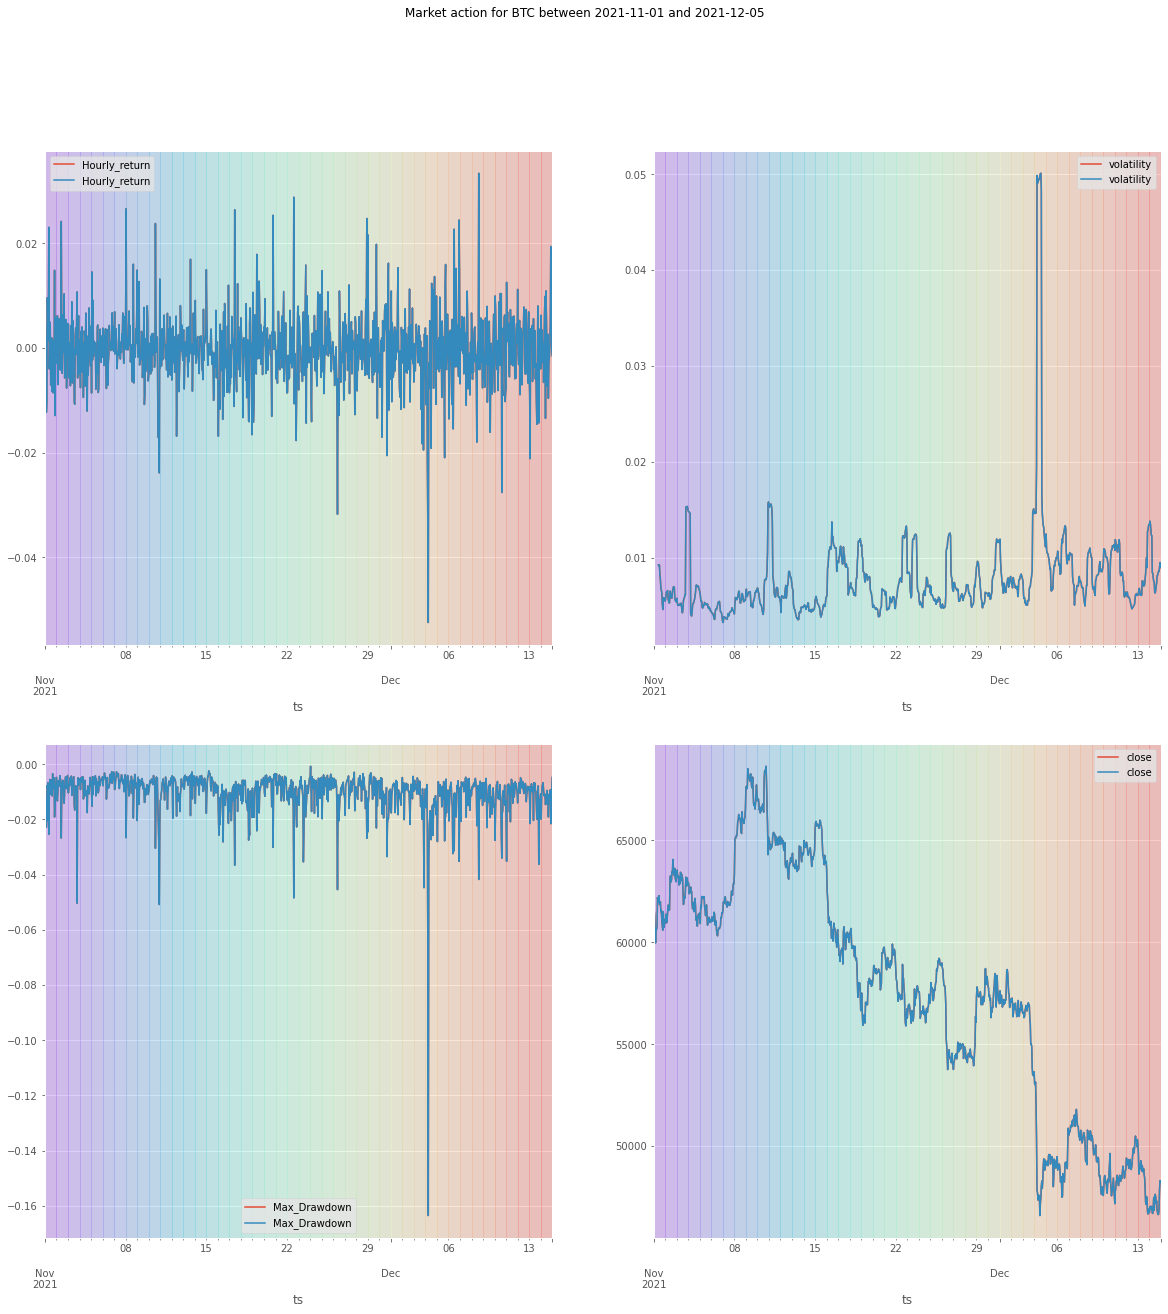

In [27]:
series_plot(df[['Hourly_return']],ax=ax[0, 0])
series_plot(df[['volatility']],ax=ax[0, 1])
series_plot(df[['Max_Drawdown']],ax=ax[1, 0])
series_plot(df[['close']],ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

In [30]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', df, encoder='pandas')
# sb.glue('summary_plot', fig, encoder='display', display=True)